### Model_V0_Part 4: Exploratory Data Analysis on Variances itself
- The purpose of this one is trying to make transition from prediction on SET index to see the behavior in volatility itself.  
- The features include lagged variance (volatility clustering), squared shock and signed squared shock (asymmetric in shock).  
- The feature generation is very similar to model V1, so to make comparison about behavior of volatility in SET index.  
- What I have found is positive coeff of lagged variance (vol clustering), positive coeff of squared shock (shock -> inc in variance) and negative coeff of signed square shock (positive shock -> dec in variance because the negativity outweighs positivity of previous coeff).  
- The caveat is about the low R-square, but since I do not try to predict variance itself, I think it is fine for the sake of exploration.

In [1]:
import pandas as pd
import numpy as np

## Many scikit-learn packages to import
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [41]:
## First, we read the dataframe that we got from the last part (part 1)
## Remember the rule of ML: analyze only training set (do not touch validating or testing set if not specified so)
Train_df = pd.read_csv('SET_Train.csv')
Validate_df = pd.read_csv('SET_Validate.csv')
Test_a_df = pd.read_csv('SET_Test_a.csv')
Test_b_df = pd.read_csv('SET_Test_b.csv')
Train_df.head()

,Date,Close,Volume,MA_diff_3,MA_diff_5,MA_diff_10,MA_diff_14,MA_diff_20,EMA_diff,MACD,...,STD_14,STD_20,Volume_Agent,Y_1,Y_3,Y_5,Y_10,Y_14,Y_20,Y_N_1
0,2008-01-02,842.97,1686634.0,0.590000,5.874,0.657,0.112857,1.1225,0.846747,-0.843428,...,19.004899,16.768455,1,-1,-1,-1,-1,-1,-1,1
1,2008-01-03,832.63,2203218.0,-6.476667,-2.130,1.501,-0.558571,-0.6085,-0.271927,-1.046243,...,18.795705,16.548025,1,-1,-1,-1,-1,-1,-1,1
2,2008-01-04,821.71,2244205.0,-12.130000,-3.898,0.781,-0.884286,-1.2365,-1.336735,-2.064332,...,18.863764,16.388750,1,-1,0,-1,-1,-1,-1,1
3,2008-01-07,808.31,1749336.0,-11.553333,-8.750,0.333,-1.770000,-1.1405,-2.543061,-3.907400,...,19.579607,17.186561,1,0,-1,-1,-1,-1,0,1
4,2008-01-08,811.69,1746730.0,-6.980000,-9.282,1.998,-1.765000,-1.0825,-1.950755,-5.037241,...,19.783006,17.660359,0,1,-1,-1,-1,-1,0,0


In [42]:
Train_df = Train_df[['STD_3', 'STD_5', 'STD_10', 'STD_14', 'STD_20', 'Close']]

In [43]:
# Take the square to transform to variance
Train_df['STD_3'] = Train_df['STD_3'] **2
Train_df['STD_5'] = Train_df['STD_5'] **2
Train_df['STD_10'] = Train_df['STD_10'] **2
Train_df['STD_14'] = Train_df['STD_14'] **2
Train_df['STD_20'] = Train_df['STD_20'] **2

In [44]:
# Generate variables to predict: variance encompassing the data of next n days
Train_df['future_STD_3'] = Train_df['STD_3'].shift(-3)
Train_df['future_STD_5'] = Train_df['STD_5'].shift(-5)
Train_df['future_STD_10'] = Train_df['STD_10'].shift(-10)
Train_df['future_STD_14'] = Train_df['STD_14'].shift(-14)
Train_df['future_STD_20'] = Train_df['STD_20'].shift(-20)

In [45]:
# Generate error_squared and error_squared_signed variable for each forecast horizon

Err_3 = Train_df['Close'] -  Train_df.loc[:, 'Close'].rolling(3).mean().shift(1)
Err_3_dir = Err_3.apply(lambda x: 1 if x > 0 else 0)
Train_df['Error_sq_3'] = Err_3 **2
Train_df['Error_signed_3'] = Train_df['Error_sq_3'] * Err_3_dir 

Err_5 = Train_df['Close'] -  Train_df.loc[:, 'Close'].rolling(5).mean().shift(1)
Err_5_dir = Err_5.apply(lambda x: 1 if x > 0 else 0)
Train_df['Error_sq_5'] = Err_5 **2
Train_df['Error_signed_5'] = Train_df['Error_sq_5'] * Err_5_dir 

Err_10 = Train_df['Close'] -  Train_df.loc[:, 'Close'].rolling(10).mean().shift(1)
Err_10_dir = Err_10.apply(lambda x: 1 if x > 0 else 0)
Train_df['Error_sq_10'] = Err_10 **2
Train_df['Error_signed_10'] = Train_df['Error_sq_10'] * Err_10_dir 

Err_14 = Train_df['Close'] -  Train_df.loc[:, 'Close'].rolling(14).mean().shift(1)
Err_14_dir = Err_14.apply(lambda x: 1 if x > 0 else 0)
Train_df['Error_sq_14'] = Err_14 **2
Train_df['Error_signed_14'] = Train_df['Error_sq_14'] * Err_14_dir 

Err_20 = Train_df['Close'] -  Train_df.loc[:, 'Close'].rolling(20).mean().shift(1)
Err_20_dir = Err_20.apply(lambda x: 1 if x > 0 else 0)
Train_df['Error_sq_20'] = Err_20 **2
Train_df['Error_signed_20'] = Train_df['Error_sq_20'] * Err_20_dir 

In [46]:
Train_df = Train_df.iloc[20:-20, :]

In [47]:
Train_df.head()

,STD_3,STD_5,STD_10,STD_14,STD_20,Close,future_STD_3,future_STD_5,future_STD_10,future_STD_14,...,Error_sq_3,Error_signed_3,Error_sq_5,Error_signed_5,Error_sq_10,Error_signed_10,Error_sq_14,Error_signed_14,Error_sq_20,Error_signed_20
20,91.694433,197.58192,427.510650,483.758345,917.858736,763.48,242.762633,143.00727,167.647129,246.957735,...,110.180011,110.180011,318.408336,318.408336,19.210689,19.210689,24.885845,0.000000,455.267569,0.000000
21,227.784033,215.33427,380.670090,436.794407,771.143051,784.23,4.276133,80.48985,165.668089,189.952592,...,899.600044,899.600044,1157.904784,1157.904784,684.607225,684.607225,337.929437,337.929437,11.475156,11.475156
22,564.097300,697.17535,577.701773,543.920423,727.590295,810.86,78.663633,68.30833,190.986477,195.956987,...,1877.777778,1877.777778,2453.022784,2453.022784,2861.929009,2861.929009,2105.629880,2105.629880,1052.191406,1052.191406
23,242.762633,686.42335,850.998850,681.556092,738.528683,811.56,63.829033,46.44883,206.727929,226.010302,...,643.636900,643.636900,1600.000000,1600.000000,2712.118084,2712.118084,2041.167858,2041.167858,1134.342400,1134.342400
24,4.276133,448.61992,958.557188,790.389077,725.129901,807.68,52.950100,97.41178,247.588627,231.314875,...,29.848011,29.848011,514.382400,514.382400,1909.253025,1909.253025,1523.340900,1523.340900,878.381406,878.381406


In [ ]:
Validate_df = Validate_df[['STD_3', 'STD_5', 'STD_10', 'STD_14', 'STD_20', 'Close']]


In [54]:
from sklearn.linear_model import LinearRegression
X3 = Train_df[['STD_3', 'Error_sq_3', 'Error_signed_3']]
Y3 = Train_df['future_STD_3']
reg3 = LinearRegression().fit(X3, Y3)
print(reg3.coef_)
print(reg3.score(X3, Y3))

[ 0.3560598   0.01316729 -0.10850597]
0.12227814683828664


In [55]:
X3 = Train_df[['STD_5', 'Error_sq_5', 'Error_signed_5']]
Y3 = Train_df['future_STD_5']
reg3 = LinearRegression().fit(X3, Y3)
print(reg3.coef_)
print(reg3.score(X3, Y3))

[ 0.2548224   0.0338041  -0.08503086]
0.1011792981799331


In [56]:
X3 = Train_df[['STD_10', 'Error_sq_10', 'Error_signed_10']]
Y3 = Train_df['future_STD_10']
reg3 = LinearRegression().fit(X3, Y3)
print(reg3.coef_)
print(reg3.score(X3, Y3))

[ 0.26339204  0.02086698 -0.06277777]
0.08952901192506957


In [57]:
X3 = Train_df[['STD_14', 'Error_sq_14', 'Error_signed_14']]
Y3 = Train_df['future_STD_14']
reg3 = LinearRegression().fit(X3, Y3)
print(reg3.coef_)
print(reg3.score(X3, Y3))

[ 0.251338    0.02982767 -0.0937908 ]
0.09663561137582122


In [58]:
X3 = Train_df[['STD_20', 'Error_sq_20', 'Error_signed_20']]
Y3 = Train_df['future_STD_20']
reg3 = LinearRegression().fit(X3, Y3)
print(reg3.coef_)
print(reg3.score(X3, Y3))

[ 0.14335229  0.03485024 -0.0633174 ]
0.049895068313853375


Text(0.5, 1.0, 'scatter plot on historical variance and future variance')

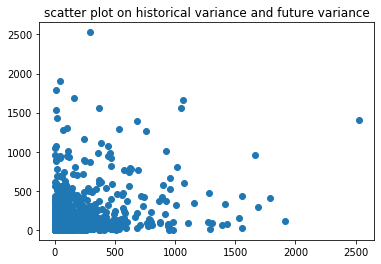

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['STD_3'], Train_df['future_STD_3'])
plt.title('scatter plot on historical variance and future variance')

Text(0.5, 1.0, 'scatter plot on historical variance and future variance')

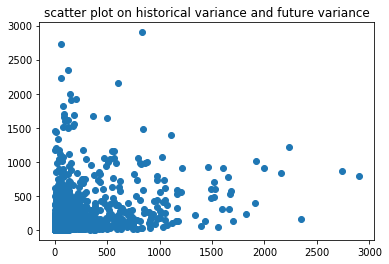

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['STD_5'], Train_df['future_STD_5'])
plt.title('scatter plot on historical variance and future variance')

Text(0.5, 1.0, 'scatter plot on historical variance and future variance')

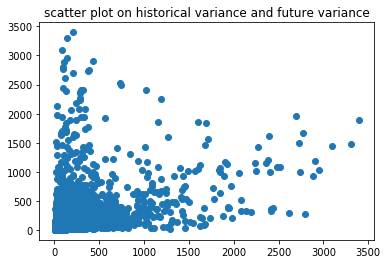

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['STD_10'], Train_df['future_STD_10'])
plt.title('scatter plot on historical variance and future variance')

Text(0.5, 1.0, 'scatter plot on historical variance and future variance')

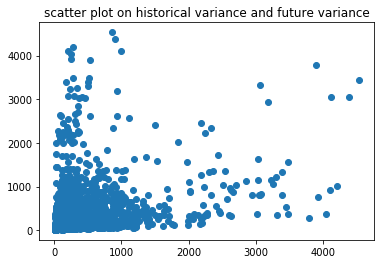

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['STD_14'], Train_df['future_STD_14'])
plt.title('scatter plot on historical variance and future variance')

Text(0.5, 1.0, 'scatter plot on historical variance and future variance')

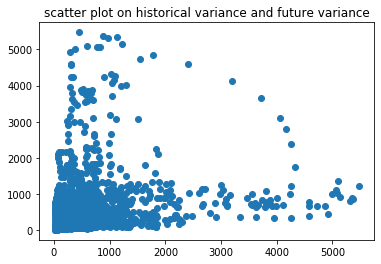

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['STD_20'], Train_df['future_STD_20'])
plt.title('scatter plot on historical variance and future variance')

Text(0.5, 1.0, 'scatter plot on squared shocks and future variance')

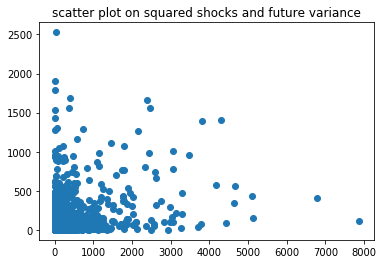

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_sq_3'], Train_df['future_STD_3'])
plt.title('scatter plot on squared shocks and future variance')

Text(0.5, 1.0, 'scatter plot on squared shocks and future variance')

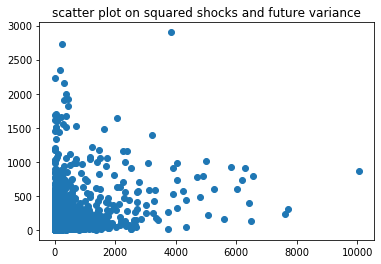

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_sq_5'], Train_df['future_STD_5'])
plt.title('scatter plot on squared shocks and future variance')

Text(0.5, 1.0, 'scatter plot on squared shocks and future variance')

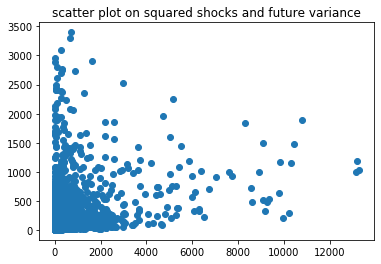

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_sq_10'], Train_df['future_STD_10'])
plt.title('scatter plot on squared shocks and future variance')

Text(0.5, 1.0, 'scatter plot on squared shocks and future variance')

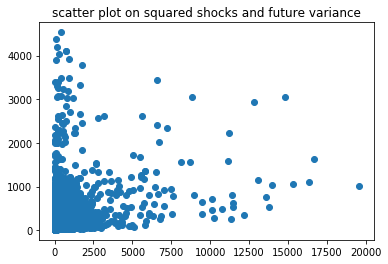

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_sq_14'], Train_df['future_STD_14'])
plt.title('scatter plot on squared shocks and future variance')

Text(0.5, 1.0, 'scatter plot on squared shocks and future variance')

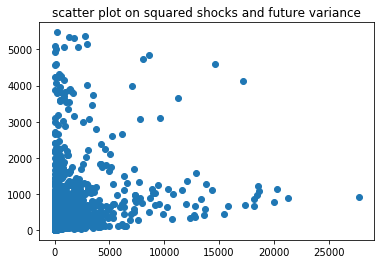

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_sq_20'], Train_df['future_STD_20'])
plt.title('scatter plot on squared shocks and future variance')

Text(0.5, 1.0, 'scatter plot on squared signed shocks and future variance')

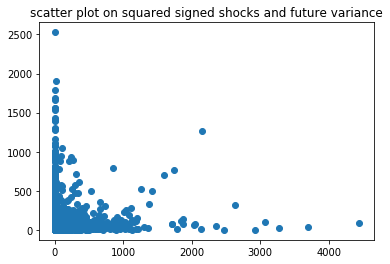

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_signed_3'], Train_df['future_STD_3'])
plt.title('scatter plot on squared signed shocks and future variance')

Text(0.5, 1.0, 'scatter plot on squared signed shocks and future variance')

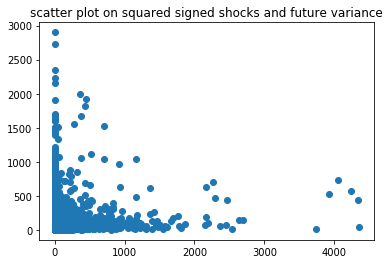

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_signed_5'], Train_df['future_STD_5'])
plt.title('scatter plot on squared signed shocks and future variance')

Text(0.5, 1.0, 'scatter plot on squared signed shocks and future variance')

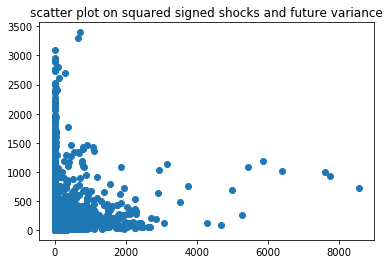

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_signed_10'], Train_df['future_STD_10'])
plt.title('scatter plot on squared signed shocks and future variance')

Text(0.5, 1.0, 'scatter plot on squared signed shocks and future variance')

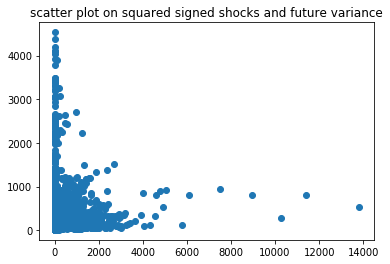

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_signed_14'], Train_df['future_STD_14'])
plt.title('scatter plot on squared signed shocks and future variance')

Text(0.5, 1.0, 'scatter plot on squared signed shocks and future variance')

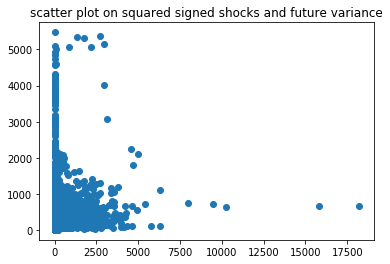

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_signed_20'], Train_df['future_STD_20'])
plt.title('scatter plot on squared signed shocks and future variance')